In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *

from pathlib import Path
import json
from PIL import ImageDraw, ImageFont
from matplotlib import patches, patheffects

In [0]:
torch.cuda.set_device(0)

## Pascal VOC

We will be looking at the [Pascal VOC](http://host.robots.ox.ac.uk/pascal/VOC/) dataset. It's quite slow, so you may prefer to download from [this mirror](https://pjreddie.com/projects/pascal-voc-dataset-mirror/). There are two different competition/research datasets, from 2007 and 2012. We'll be using the 2007 version. You can use the larger 2012 for better results, or even combine them (but be careful to avoid data leakage between the validation sets if you do this).

Unlike previous lessons, we are using the python 3 standard library `pathlib` for our paths and file access. Note that it returns an OS-specific class (on Linux, `PosixPath`) so your output may look a little different. Most libraries than take paths as input can take a pathlib object - although some (like `cv2`) can't, in which case you can use `str()` to convert it to a string.

In [10]:
PATH = Path('data/pascal')
list(PATH.iterdir())

[PosixPath('data/pascal/pascal_test2007.json'),
 PosixPath('data/pascal/pascal_val2012.json'),
 PosixPath('data/pascal/pascal_train2007.json'),
 PosixPath('data/pascal/pascal_train2012.json'),
 PosixPath('data/pascal/PASCAL_VOC.zip'),
 PosixPath('data/pascal/pascal_val2007.json')]

As well as the images, there are also *annotations* - *bounding boxes* showing where each object is. These were hand labeled. The original version were in XML, which is a little hard to work with nowadays, so we uses the more recent JSON version which you can download from [this link](https://storage.googleapis.com/coco-dataset/external/PASCAL_VOC.zip).

You can see here how `pathlib` includes the ability to open files (amongst many other capabilities).

In [11]:
trn_j = json.load((PATH/'pascal_train2007.json').open())
trn_j.keys()

dict_keys(['images', 'type', 'annotations', 'categories'])

In [12]:
IMAGES,ANNOTATIONS,CATEGORIES = ['images', 'annotations', 'categories']
trn_j[IMAGES][:5]

[{'file_name': '000012.jpg', 'height': 333, 'id': 12, 'width': 500},
 {'file_name': '000017.jpg', 'height': 364, 'id': 17, 'width': 480},
 {'file_name': '000023.jpg', 'height': 500, 'id': 23, 'width': 334},
 {'file_name': '000026.jpg', 'height': 333, 'id': 26, 'width': 500},
 {'file_name': '000032.jpg', 'height': 281, 'id': 32, 'width': 500}]

In [13]:
trn_j[ANNOTATIONS][:2]

[{'area': 34104,
  'bbox': [155, 96, 196, 174],
  'category_id': 7,
  'id': 1,
  'ignore': 0,
  'image_id': 12,
  'iscrowd': 0,
  'segmentation': [[155, 96, 155, 270, 351, 270, 351, 96]]},
 {'area': 13110,
  'bbox': [184, 61, 95, 138],
  'category_id': 15,
  'id': 2,
  'ignore': 0,
  'image_id': 17,
  'iscrowd': 0,
  'segmentation': [[184, 61, 184, 199, 279, 199, 279, 61]]}]

In [14]:
trn_j[CATEGORIES][:4]

[{'id': 1, 'name': 'aeroplane', 'supercategory': 'none'},
 {'id': 2, 'name': 'bicycle', 'supercategory': 'none'},
 {'id': 3, 'name': 'bird', 'supercategory': 'none'},
 {'id': 4, 'name': 'boat', 'supercategory': 'none'}]

It's helpful to use constants instead of strings, since we get tab-completion and don't mistype.

In [0]:
FILE_NAME,ID,IMG_ID,CAT_ID,BBOX = 'file_name','id','image_id','category_id','bbox'

cats = {o[ID]:o['name'] for o in trn_j[CATEGORIES]}
trn_fns = {o[ID]:o[FILE_NAME] for o in trn_j[IMAGES]}
trn_ids = [o[ID] for o in trn_j[IMAGES]]

In [17]:
list((PATH/'VOCdevkit'/'VOC2007').iterdir())

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationObject'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/SegmentationClass'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/Annotations'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/ImageSets')]

In [0]:
JPEGS = 'VOCdevkit/VOC2007/JPEGImages'

In [19]:
IMG_PATH = PATH/JPEGS
list(IMG_PATH.iterdir())[:5]

[PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/002132.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/003008.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/001684.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/009086.jpg'),
 PosixPath('data/pascal/VOCdevkit/VOC2007/JPEGImages/005718.jpg')]

Each image has a unique ID.

In [20]:
im0_d = trn_j[IMAGES][0]
im0_d[FILE_NAME],im0_d[ID]

('000012.jpg', 12)

A `defaultdict` is useful any time you want to have a default dictionary entry for new keys. Here we create a dict from image IDs to a list of annotations (tuple of bounding box and class id).

We convert VOC's height/width into top-left/bottom-right, and switch x/y coords to be consistent with numpy.

In [21]:
def hw_bb(bb): return np.array([bb[1], bb[0], bb[3]+bb[1]-1, bb[2]+bb[0]-1])

trn_anno = collections.defaultdict(lambda:[])
for o in trn_j[ANNOTATIONS]:
    if not o['ignore']:
        bb = o[BBOX]
        bb = hw_bb(bb)
        trn_anno[o[IMG_ID]].append((bb,o[CAT_ID]))
        
len(trn_anno)

2501

In [22]:
im_a = trn_anno[im0_d[ID]]; im_a

[(array([ 96, 155, 269, 350]), 7)]

In [23]:
im0_a = im_a[0]; im0_a

(array([ 96, 155, 269, 350]), 7)

In [24]:
cats[7]

'car'

In [25]:
trn_anno[17]

[(array([ 61, 184, 198, 278]), 15), (array([ 77,  89, 335, 402]), 13)]

In [26]:
cats[15],cats[13]

('person', 'horse')

Some libs take VOC format bounding boxes, so this let's us convert back when required:

In [0]:
bb_voc = [155, 96, 196, 174]
bb_fastai = hw_bb(bb_voc)

In [0]:
def bb_hw(a): return np.array([a[1],a[0],a[3]-a[1]+1,a[2]-a[0]+1])

In [29]:
f'expected: {bb_voc}, actual: {bb_hw(bb_fastai)}'

'expected: [155, 96, 196, 174], actual: [155  96 196 174]'

You can use [Visual Studio Code](https://code.visualstudio.com/) (vscode - open source editor that comes with recent versions of Anaconda, or can be installed separately), or most editors and IDEs, to find out all about the `open_image` function. vscode things to know:

- Command palette (<kbd>Ctrl-shift-p</kbd>)
- Select interpreter (for fastai env)
- Select terminal shell
- Go to symbol (<kbd>Ctrl-t</kbd>)
- Find references (<kbd>Shift-F12</kbd>)
- Go to definition (<kbd>F12</kbd>)
- Go back (<kbd>alt-left</kbd>)
- View documentation
- Hide sidebar (<kbd>Ctrl-b</kbd>)
- Zen mode (<kbd>Ctrl-k,z</kbd>)

In [0]:
im = open_image(IMG_PATH/im0_d[FILE_NAME])

Matplotlib's `plt.subplots` is a really useful wrapper for creating plots, regardless of whether you have more than one subplot. Note that Matplotlib has an optional object-oriented API which I think is much easier to understand and use (although few examples online use it!)

In [0]:
def show_img(im, figsize=None, ax=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    return ax

A simple but rarely used trick to making text visible regardless of background is to use white text with black outline, or visa versa. Here's how to do it in matplotlib.

In [0]:
def draw_outline(o, lw):
    o.set_path_effects([patheffects.Stroke(
        linewidth=lw, foreground='black'), patheffects.Normal()])

Note that `*` in argument lists is the [splat operator](https://stackoverflow.com/questions/5239856/foggy-on-asterisk-in-python). In this case it's a little shortcut compared to writing out `b[-2],b[-1]`.

In [0]:
def draw_rect(ax, b):
    patch = ax.add_patch(patches.Rectangle(b[:2], *b[-2:], fill=False, edgecolor='white', lw=2))
    draw_outline(patch, 4)

In [0]:
def draw_text(ax, xy, txt, sz=14):
    text = ax.text(*xy, txt,
        verticalalignment='top', color='white', fontsize=sz, weight='bold')
    draw_outline(text, 1)

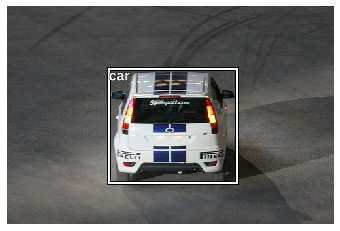

In [35]:
ax = show_img(im)
b = bb_hw(im0_a[0])
draw_rect(ax, b)
draw_text(ax, b[:2], cats[im0_a[1]])

In [0]:
def draw_im(im, ann):
    ax = show_img(im, figsize=(16,8))
    for b,c in ann:
        b = bb_hw(b)
        draw_rect(ax, b)
        draw_text(ax, b[:2], cats[c], sz=16)

In [0]:
def draw_idx(i):
    im_a = trn_anno[i]
    im = open_image(IMG_PATH/trn_fns[i])
    print(im.shape)
    draw_im(im, im_a)

(364, 480, 3)


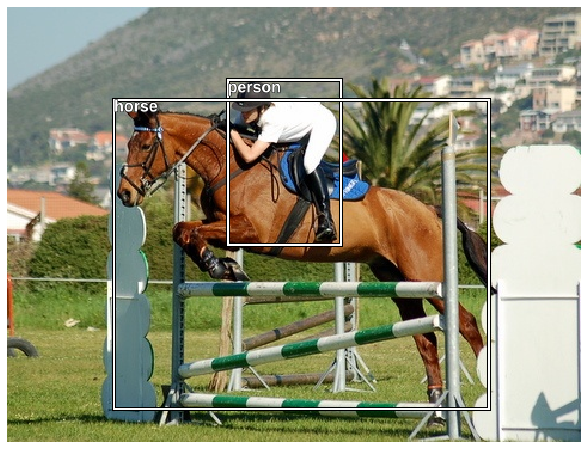

In [38]:
draw_idx(17)

## Largest item classifier

A *lambda function* is simply a way to define an anonymous function inline. Here we use it to describe how to sort the annotation for each image - by bounding box size (descending).

In [0]:
def get_lrg(b):
    if not b: raise Exception()
    b = sorted(b, key=lambda x: np.product(x[0][-2:]-x[0][:2]), reverse=True)
    return b[0]

In [0]:
trn_lrg_anno = {a: get_lrg(b) for a,b in trn_anno.items()}

Now we have a dictionary from image id to a single bounding box - the largest for that image.

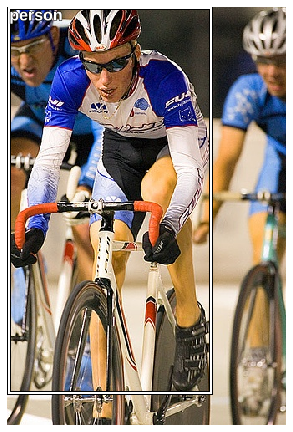

In [41]:
b,c = trn_lrg_anno[23]
b = bb_hw(b)
ax = show_img(open_image(IMG_PATH/trn_fns[23]), figsize=(5,10))
draw_rect(ax, b)
draw_text(ax, b[:2], cats[c], sz=16)

In [0]:
(PATH/'tmp').mkdir(exist_ok=True)
CSV = PATH/'tmp/lrg.csv'

Often it's easiest to simply create a CSV of the data you want to model, rather than trying to create a custom dataset. Here we use Pandas to help us create a CSV of the image filename and class.

In [0]:
df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids],
    'cat': [cats[trn_lrg_anno[o][1]] for o in trn_ids]}, columns=['fn','cat'])
df.to_csv(CSV, index=False)

In [0]:
f_model = resnet34
sz=224
bs=64

From here it's just like Dogs vs Cats!

In [0]:
tfms = tfms_from_model(f_model, sz, aug_tfms=transforms_side_on, crop_type=CropType.NO)
md = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms, bs=bs)

In [0]:
x,y=next(iter(md.val_dl))

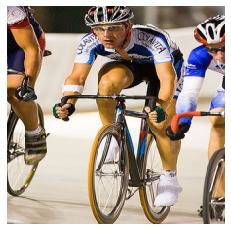

In [47]:
show_img(md.val_ds.denorm(to_np(x))[0]);

In [48]:
learn = ConvLearner.pretrained(f_model, md, metrics=[accuracy])
learn.opt_fn = optim.Adam

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 49198969.19it/s]


In [49]:
lrf=learn.lr_find(1e-5,100)

Widget Javascript not detected.  It may not be installed or enabled properly.


 78%|███████▊  | 25/32 [00:21<00:02,  3.30it/s, loss=10.9]

When you LR finder graph looks like this, you can ask for more points on each end:

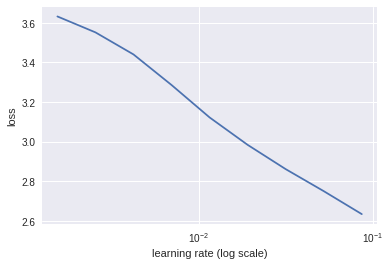

In [50]:
learn.sched.plot()

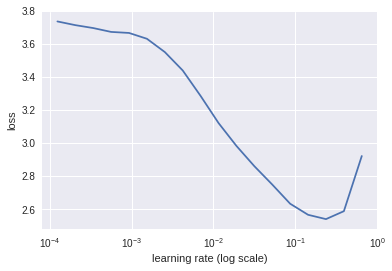

In [51]:
learn.sched.plot(n_skip=5, n_skip_end=1)

In [0]:
lr = 2e-2

In [53]:
learn.fit(lr, 1, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      1.265113   0.620414   0.798     


[array([0.62041]), 0.7980000014305115]

In [0]:
lrs = np.array([lr/1000,lr/100,lr])

In [0]:
learn.freeze_to(-2)

Widget Javascript not detected.  It may not be installed or enabled properly.


 84%|████████▍ | 27/32 [00:24<00:02,  1.70it/s, loss=4.89]

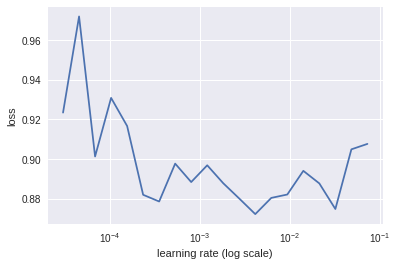

In [56]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [57]:
learn.fit(lrs/5, 1, cycle_len=1)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.793196   0.599119   0.82      


[array([0.59912]), 0.8199999995231628]

In [0]:
learn.unfreeze()

Accuracy isn't improving much - since many images have multiple different objects, it's going to be impossible to be that accurate.

In [59]:
learn.fit(lrs/5, 1, cycle_len=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   accuracy   
    0      0.625364   0.634549   0.812     
    1      0.443942   0.601781   0.816     


[array([0.60178]), 0.8160000023841858]

In [0]:
learn.save('clas_one')

In [0]:
learn.load('clas_one')

In [0]:
x,y = next(iter(md.val_dl))
probs = F.softmax(predict_batch(learn.model, x), -1)
x,preds = to_np(x),to_np(probs)
preds = np.argmax(preds, -1)

You can use the python debugger `pdb` to step through code.

- `pdb.set_trace()` to set a breakpoint
- `%debug` magic to trace an error

Commands you need to know:

- s / n / c
- u / d
- p
- l

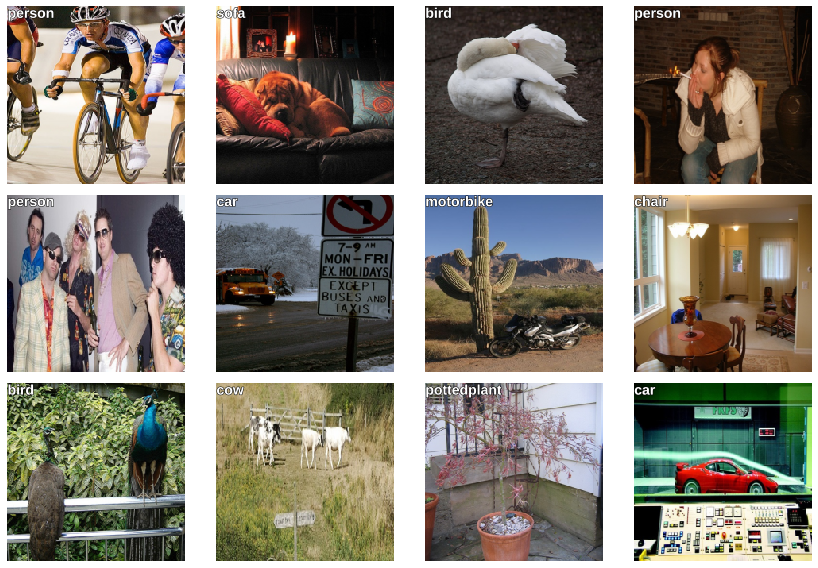

In [63]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(x)[i]
    b = md.classes[preds[i]]
    ax = show_img(ima, ax=ax)
    draw_text(ax, (0,0), b)
plt.tight_layout()

It's doing a pretty good job of classifying the largest object!

## Bbox only

Now we'll try to find the bounding box of the largest object. This is simply a regression with 4 outputs. So we can use a CSV with multiple 'labels'.

In [0]:
BB_CSV = PATH/'tmp/bb.csv'

In [0]:
bb = np.array([trn_lrg_anno[o][0] for o in trn_ids])
bbs = [' '.join(str(p) for p in o) for o in bb]

df = pd.DataFrame({'fn': [trn_fns[o] for o in trn_ids], 'bbox': bbs}, columns=['fn','bbox'])
df.to_csv(BB_CSV, index=False)

In [66]:
BB_CSV.open().readlines()[:5]

['fn,bbox\n',
 '000012.jpg,96 155 269 350\n',
 '000017.jpg,77 89 335 402\n',
 '000023.jpg,1 2 461 242\n',
 '000026.jpg,124 89 211 336\n']

In [0]:
f_model=resnet34
sz=224
bs=64

Set `continuous=True` to tell fastai this is a regression problem, which means it won't one-hot encode the labels, and will use MSE as the default crit.

Note that we have to tell the transforms constructor that our labels are coordinates, so that it can handle the transforms correctly.

Also, we use CropType.NO because we want to 'squish' the rectangular images into squares, rather than center cropping, so that we don't accidentally crop out some of the objects. (This is less of an issue in something like imagenet, where there is a single object to classify, and it's generally large and centrally located).

In [0]:
augs = [RandomFlip(), 
        RandomRotate(30),
        RandomLighting(0.1,0.1)]

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]
[115.  63. 241. 312.]


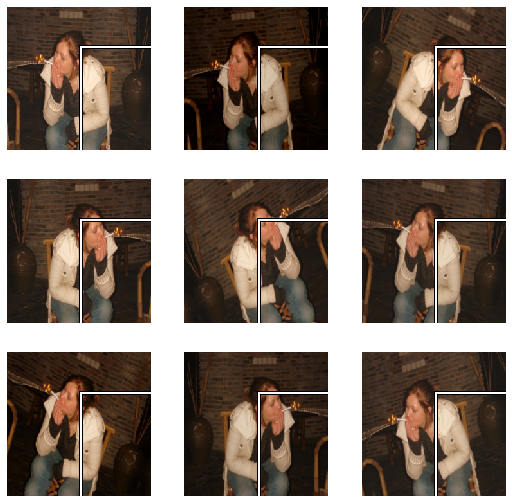

In [70]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [0]:
augs = [RandomFlip(tfm_y=TfmType.COORD),
        RandomRotate(30, tfm_y=TfmType.COORD),
        RandomLighting(0.1,0.1, tfm_y=TfmType.COORD)]

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, continuous=True, bs=4)

[ 62.  33. 114. 190.]
[ 23.  11. 154. 212.]
[ 38.  23. 144. 200.]
[ 36.  21. 150. 202.]
[ 66.  38. 105. 183.]
[ 42.  27. 132. 196.]
[ 37.  22. 145. 201.]
[ 52.  38. 106. 183.]
[ 35.  22. 134. 201.]


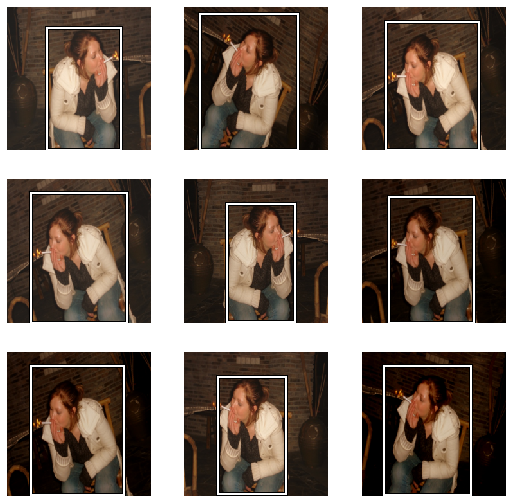

In [73]:
idx=3
fig,axes = plt.subplots(3,3, figsize=(9,9))
for i,ax in enumerate(axes.flat):
    x,y=next(iter(md.aug_dl))
    ima=md.val_ds.denorm(to_np(x))[idx]
    b = bb_hw(to_np(y[idx]))
    print(b)
    show_img(ima, ax=ax)
    draw_rect(ax, b)

In [0]:
tfm_y = TfmType.COORD
augs = [RandomFlip(tfm_y=tfm_y),
        RandomRotate(3, p=0.5, tfm_y=tfm_y),
        RandomLighting(0.05,0.05, tfm_y=tfm_y)]

tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=tfm_y, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms, bs=bs, continuous=True)

fastai let's you use a `custom_head` to add your own module on top of a convnet, instead of the adaptive pooling and fully connected net which is added by default. In this case, we don't want to do any pooling, since we need to know the activations of each grid cell.

The final layer has 4 activations, one per bounding box coordinate. Our target is continuous, not categorical, so the MSE loss function used does not do any sigmoid or softmax to the module outputs.

In [76]:
512*7*7

25088

In [0]:
head_reg4 = nn.Sequential(Flatten(), nn.Linear(25088,4))
learn = ConvLearner.pretrained(f_model, md, custom_head=head_reg4)
learn.opt_fn = optim.Adam
learn.crit = nn.L1Loss()

In [78]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 224, 224]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 112, 112]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 112, 112]),
                           ('output_shape', [-1, 64, 56, 56]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 56, 

Widget Javascript not detected.  It may not be installed or enabled properly.


 78%|███████▊  | 25/32 [00:25<00:07,  1.10s/it, loss=512]

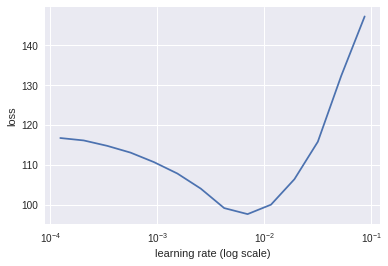

In [79]:
learn.lr_find(1e-5,100)
learn.sched.plot(5)

In [0]:
lr = 2e-3

In [81]:
learn.fit(lr, 2, cycle_len=1, cycle_mult=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   
    0      50.199921  35.027664 
    1      38.059465  28.319166 
    2      32.159539  27.910007 


[array([27.91001])]

In [0]:
lrs = np.array([lr/100,lr/10,lr])

In [0]:
learn.freeze_to(-2)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   
    0      66.413002  8.47986784306253e+16


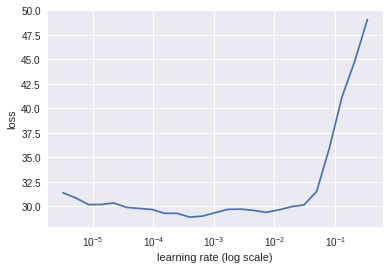

In [84]:
lrf=learn.lr_find(lrs/1000)
learn.sched.plot(1)

In [85]:
learn.fit(lrs, 2, cycle_len=1, cycle_mult=2)

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   
    0      26.846167  23.427758 
    1      23.188343  21.323571 
    2      19.71856   19.738401 


[array([19.7384])]

In [0]:
learn.freeze_to(-3)

In [87]:
learn.fit(lrs, 1, cycle_len=2)

epoch      trn_loss   val_loss   
    0      19.572405  22.233971 
    1      16.767031  19.933301 


[array([19.9333])]

In [0]:
learn.save('reg4')

In [0]:
learn.load('reg4')

In [0]:
x,y = next(iter(md.val_dl))
learn.model.eval()
preds = to_np(learn.model(VV(x)))

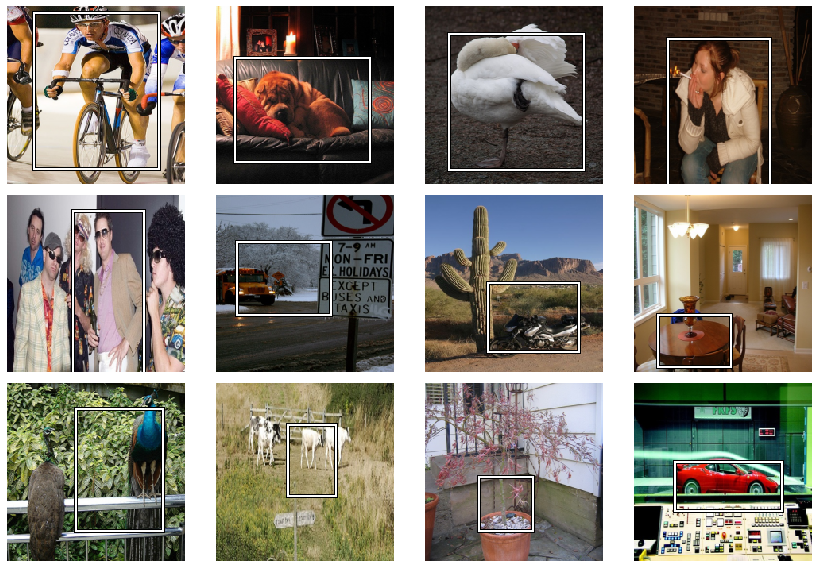

In [91]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.denorm(to_np(x))[i]
    b = bb_hw(preds[i])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
plt.tight_layout()

## Single object detection

In [0]:
f_model=resnet34
sz=224
bs=64

val_idxs = get_cv_idxs(len(trn_fns))

In [0]:
tfms = tfms_from_model(f_model, sz, crop_type=CropType.NO, tfm_y=TfmType.COORD, aug_tfms=augs)
md = ImageClassifierData.from_csv(PATH, JPEGS, BB_CSV, tfms=tfms,
   bs=bs, continuous=True, val_idxs=val_idxs)

In [0]:
md2 = ImageClassifierData.from_csv(PATH, JPEGS, CSV, tfms=tfms_from_model(f_model, sz))

A dataset can be anything with `__len__` and `__getitem__`. Here's a dataset that adds a 2nd label to an existing dataset:

In [0]:
class ConcatLblDataset(Dataset):
    def __init__(self, ds, y2): self.ds,self.y2 = ds,y2
    def __len__(self): return len(self.ds)
    
    def __getitem__(self, i):
        x,y = self.ds[i]
        return (x, (y,self.y2[i]))

We'll use it to add the classes to the bounding boxes labels.

In [0]:
trn_ds2 = ConcatLblDataset(md.trn_ds, md2.trn_y)
val_ds2 = ConcatLblDataset(md.val_ds, md2.val_y)

In [97]:
val_ds2[0][1]

(array([  0.,  49., 205., 180.], dtype=float32), 14)

We can replace the dataloaders' datasets with these new ones.

In [0]:
md.trn_dl.dataset = trn_ds2
md.val_dl.dataset = val_ds2

We have to `denorm`alize the images from the dataloader before they can be plotted.

In [99]:
x,y=next(iter(md.val_dl))
idx=3
ima=md.val_ds.ds.denorm(to_np(x))[idx]
b = bb_hw(to_np(y[0][idx])); b

array([ 52.,  38., 107., 185.])

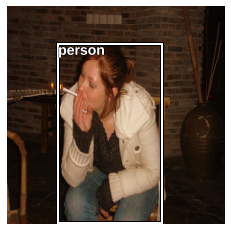

In [100]:
ax = show_img(ima)
draw_rect(ax, b)
draw_text(ax, b[:2], md2.classes[y[1][idx]])

We need one output activation for each class (for its probability) plus one for each bounding box coordinate. We'll use an extra linear layer this time, plus some dropout, to help us train a more flexible model.

In [0]:
head_reg4 = nn.Sequential(
    Flatten(),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(25088,256),
    nn.ReLU(),
    nn.BatchNorm1d(256),
    nn.Dropout(0.5),
    nn.Linear(256,4+len(cats)),
)
models = ConvnetBuilder(f_model, 0, 0, 0, custom_head=head_reg4)

learn = ConvLearner(md, models)
learn.opt_fn = optim.Adam

In [0]:
def detn_loss(input, target):
    bb_t,c_t = target
    bb_i,c_i = input[:, :4], input[:, 4:]
    bb_i = F.sigmoid(bb_i)*224
    # I looked at these quantities separately first then picked a multiplier
    #   to make them approximately equal
    return F.l1_loss(bb_i, bb_t) + F.cross_entropy(c_i, c_t)*20

def detn_l1(input, target):
    bb_t,_ = target
    bb_i = input[:, :4]
    bb_i = F.sigmoid(bb_i)*224
    return F.l1_loss(V(bb_i),V(bb_t)).data

def detn_acc(input, target):
    _,c_t = target
    c_i = input[:, 4:]
    return accuracy(c_i, c_t)

learn.crit = detn_loss
learn.metrics = [detn_acc, detn_l1]

Widget Javascript not detected.  It may not be installed or enabled properly.


 97%|█████████▋| 31/32 [00:27<00:00,  2.46it/s, loss=778]

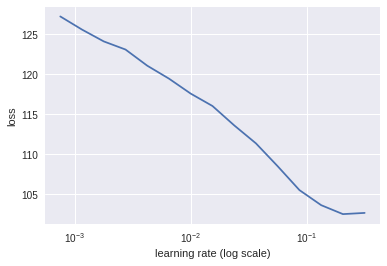

In [103]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=1e-2

In [105]:
learn.fit(lr, 1, cycle_len=3, use_clr=(32,5))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      73.590027  44.547638  0.792      31.193515 
    1      53.130809  36.986735  0.824      25.735209 
    2      44.179743  35.804691  0.832      25.021962 


[array([35.80469]), 0.8320000023841858, 25.021961669921875]

In [0]:
learn.save('reg1_0')

In [0]:
learn.freeze_to(-2)

In [0]:
lrs = np.array([lr/100, lr/10, lr])

Widget Javascript not detected.  It may not be installed or enabled properly.


 91%|█████████ | 29/32 [00:30<00:01,  1.60it/s, loss=246]

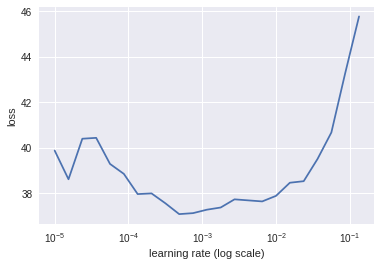

In [109]:
learn.lr_find(lrs/1000)
learn.sched.plot(0)

In [110]:
learn.fit(lrs/5, 1, cycle_len=5, use_clr=(32,10))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      37.235386  36.334278  0.768      22.94944  
    1      32.190443  33.233991  0.808      21.641065 
    2      27.694154  31.02569   0.834      20.633831 
    3      24.268213  29.967221  0.842      19.997332 
    4      21.723855  29.634042  0.846      19.564372 


[array([29.63404]), 0.8460000023841858, 19.564372131347657]

In [0]:
learn.save('reg1_1')

In [0]:
learn.load('reg1_1')

In [0]:
learn.unfreeze()

In [117]:
learn.fit(lrs/10, 1, cycle_len=10, use_clr=(32,10))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   detn_acc   detn_l1    
    0      19.005134  31.087999  0.83       19.86186  
    1      18.440732  31.272986  0.822      19.872512 
    2      17.835576  30.683097  0.826      19.371113 
    3      16.868013  31.085599  0.814      19.11172  
    4      15.908137  30.379425  0.826      18.791227 
    5      15.153358  29.989009  0.828      18.581803 
    6      14.388677  29.96062   0.828      18.527042 
    7      13.594547  30.405117  0.822      18.416381 
    8      13.049005  29.68714   0.82       18.235089 
    9      12.817073  29.794549  0.826      18.190586 


[array([29.79455]), 0.8259999995231628, 18.190585647583006]

In [0]:
learn.save('reg1')

In [0]:
learn.load('reg1')

In [0]:
y = learn.predict()
x,_ = next(iter(md.val_dl))

In [0]:
from scipy.special import expit

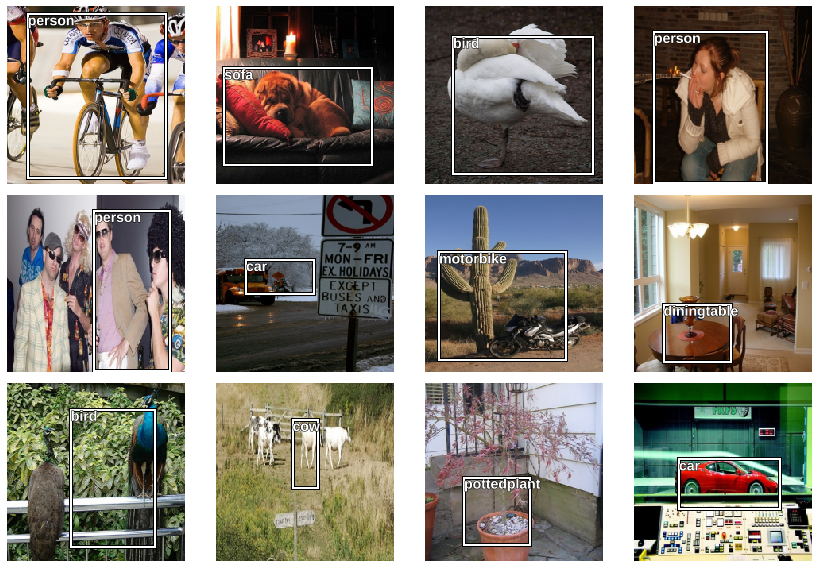

In [122]:
fig, axes = plt.subplots(3, 4, figsize=(12, 8))
for i,ax in enumerate(axes.flat):
    ima=md.val_ds.ds.denorm(to_np(x))[i]
    bb = expit(y[i][:4])*224
    b = bb_hw(bb)
    c = np.argmax(y[i][4:])
    ax = show_img(ima, ax=ax)
    draw_rect(ax, b)
    draw_text(ax, b[:2], md2.classes[c])
plt.tight_layout()

## End